## Binary Image Classification Using Transfer Learning

Qurat Ul Ain Syeda

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [2]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data2",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data2",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 546 files belonging to 2 classes.
Using 437 files for training.
Found 546 files belonging to 2 classes.
Using 109 files for validation.


In [3]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

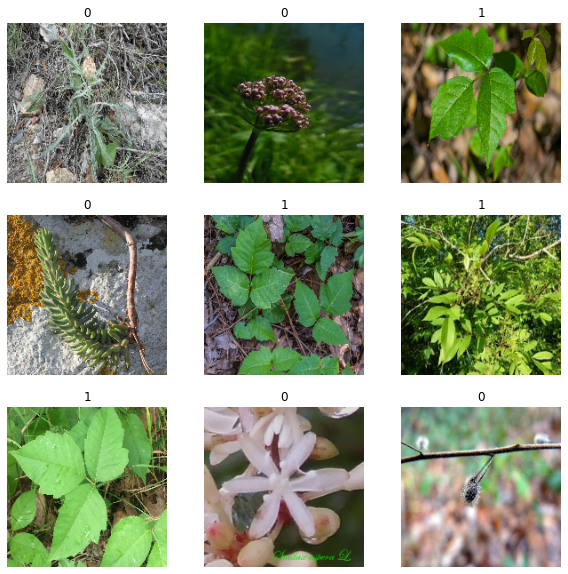

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        #layers.RandomCrop(),
        #layers.RandomTranslation(),
        #layers.RandomZoom(),
        #layers.RandomHeight(),
        #layers.RandomWidth(),
        #layers.RandomContrast(),
    ]
)

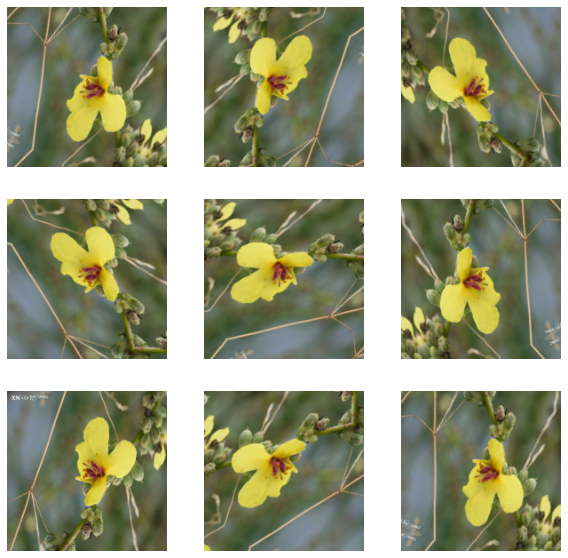

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
#Standardize the data
size = (180, 180)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
#test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(180, 180, 3),
    include_top=False) # Do not include the ImageNet classifier at the top.

In [10]:
base_model.trainable = False

In [11]:
# Create new model on top
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

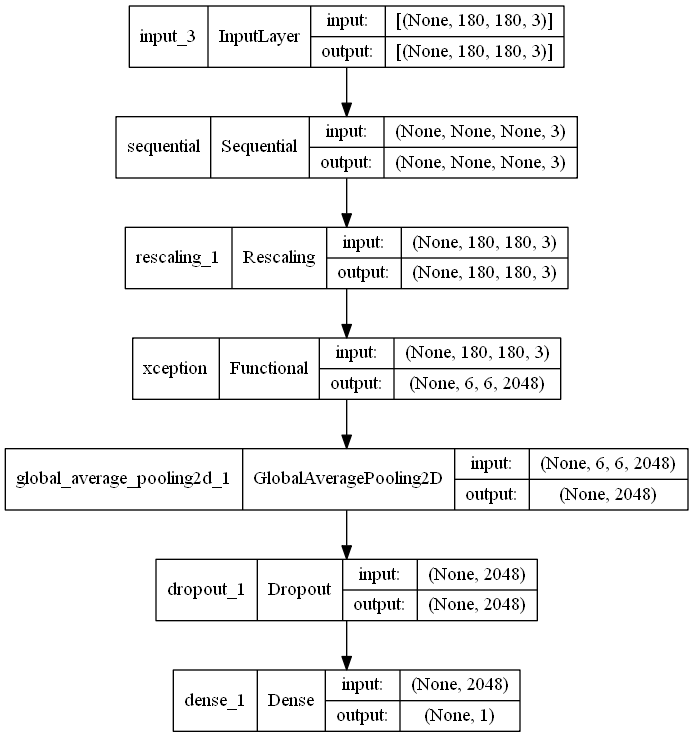

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
#Train the top layer
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)


epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 0.5586 - accuracy: 0.7368 - val_loss: 0.4712 - val_accuracy: 0.8073
Epoch 2/20
14/14 [==============================] - 38s 3s/step - loss: 0.4095 - accuracy: 0.8535 - val_loss: 0.3893 - val_accuracy: 0.8073
Epoch 3/20
14/14 [==============================] - 40s 3s/step - loss: 0.3456 - accuracy: 0.8558 - val_loss: 0.3678 - val_accuracy: 0.8257
Epoch 4/20
14/14 [==============================] - 36s 2s/step - loss: 0.3410 - accuracy: 0.8764 - val_loss: 0.3471 - val_accuracy: 0.8532
Epoch 5/20
14/14 [==============================] - 38s 3s/step - loss: 0.3107 - accuracy: 0.8970 - val_loss: 0.3423 - val_accuracy: 0.8624
Epoch 6/20
14/14 [==============================] - 36s 3s/step - loss: 0.2861 - accuracy: 0.9016 - val_loss: 0.3405 - val_accuracy: 0.8624
Epoch 7/20
14/14 [==============================] - 38s 3s/step - loss: 0.2734 - accuracy: 0.8993 - val_loss: 0.3310 - val_accuracy: 0.8624
Epoch 8/20
14/14 [==

In [14]:
model.evaluate(val_ds)

4/4 [==============================] - 8s 2s/step - loss: 0.3043 - accuracy: 0.8716


[0.3043314516544342, 0.8715596199035645]

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

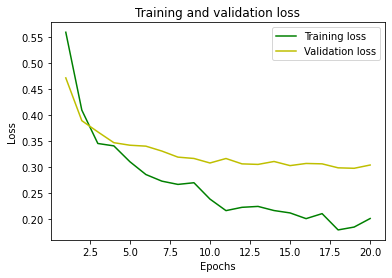

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

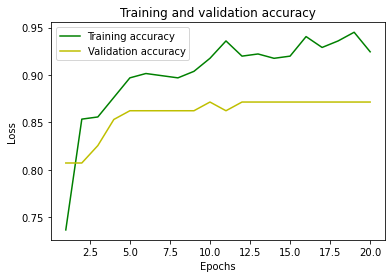

In [17]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Fine-tuning the Entire Model

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

epochs = 25
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [20]:
model.evaluate(val_ds)

4/4 [==============================] - 8s 2s/step - loss: 0.3835 - accuracy: 0.9083


[0.38352280855178833, 0.9082568883895874]

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

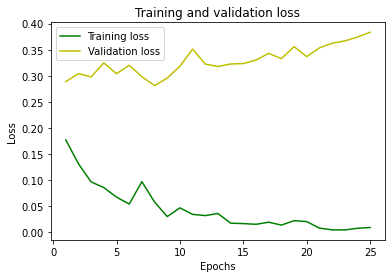

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

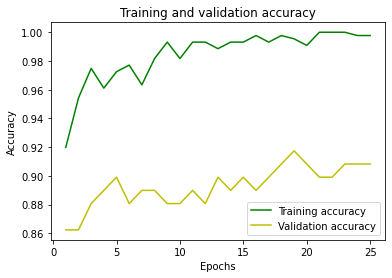

In [28]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Predicting on Test Set

This image is 0.00 percent non-poisonous and 100.00 percent poisonous.


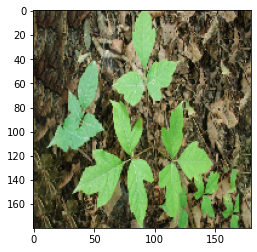

In [24]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/Ivy-46.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent non-poisonous and 100.00 percent poisonous.


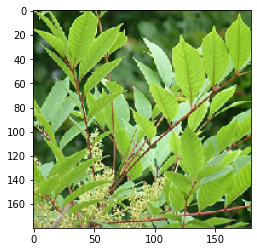

In [25]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/poison_sumac_50.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent non-poisonous and 100.00 percent poisonous.


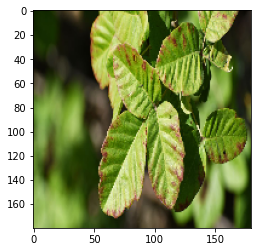

In [26]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/Oak-46.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent non-poisonous and 0.00 percent poisonous.


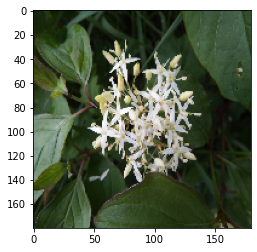

In [27]:
img = keras.preprocessing.image.load_img(
    "Dataset/Test/test_folder/2409.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image is %.2f percent non-poisonous and %.2f percent poisonous."
    % (100 * (1 - score), 100 * score)
)